In [92]:
include("../src/HPFEM.jl")

HPFEM

In [93]:
nel = 2
nnodes = nel + 1
idir = [1,nnodes]
M = 15
Q = M+2
bas = HPFEM.Basis1d(M,Q)
lmap = HPFEM.locmap(bas)
dof = HPFEM.DofMap1d(lmap, nnodes, idir);


In [94]:
fun(x) = (1 + 4*pi^2)*sin(2*pi*x)
resp(x) = sin(2*pi*x)

resp (generic function with 1 method)

In [95]:
a = -1
b = 1
nodes = collect(linspace(a, b, nnodes))

3-element Array{Float64,1}:
 -1.0
  0.0
  1.0

In [96]:
elems = [HPFEM.Element1d(e, nodes[e], nodes[e+1], bas) for e = 1:nel];

In [97]:
solver = HPFEM.CholeskySC(dof, HPFEM.BBMatrix);

In [98]:
for e = 1:nel
    Ae = HPFEM.mass_matrix(bas, elems[e])
    Se = HPFEM.stiff_matrix(bas,elems[e])
    Ae =  Ae + Se
    HPFEM.add_local_matrix(solver, e, Ae)
end


In [99]:
Fe = zeros(HPFEM.nmodes(lmap), nel)
for e = 1:nel
    fe = fun(elems[e].x)
    HPFEM.add_rhs!(bas, elems[e], fe, sub(Fe, :, e))
end

# Apply Dirichilet BCs:
Fe[1,1] = resp(a)
Fe[2,nel]= resp(b)
Fe = Fe


15x2 Array{Float64,2}:
  2.44929e-16   6.44234    
 -6.44234      -2.44929e-16
 -2.81676e-16   2.94903e-16
 -3.91647      -3.91647    
  1.58294e-16  -2.31586e-16
  1.6677        1.6677     
  1.81279e-16   1.06685e-16
 -0.196584     -0.196584   
  1.94289e-16   1.249e-16  
  0.0109091     0.0109091  
  1.82146e-17  -5.20417e-17
 -0.000353398  -0.000353398
 -2.10769e-16  -2.56739e-16
  7.51952e-6    7.51952e-6 
 -3.70363e-16   9.06393e-17

In [100]:
HPFEM.solve!(solver, Fe)

15x2 Array{Float64,2}:
  2.44929e-16   3.38216e-16
  3.38216e-16  -2.44929e-16
  1.91186e-15   3.59002e-15
 -4.77465      -4.77465    
  2.77489e-15   2.48406e-15
  0.914905      0.914905   
  1.19087e-15   1.15746e-15
 -0.0692349    -0.0692349  
 -8.2144e-16   -8.42691e-16
  0.00282614    0.00282614 
 -1.13815e-15  -1.15463e-15
 -7.23801e-5   -7.23801e-5 
 -2.47824e-16  -2.5653e-16 
  1.27323e-6    1.27323e-6 
  8.07207e-17   1.54318e-16

In [101]:
nξ = 101
ξ = collect(linspace(-1,1,nξ));
ϕ = zeros(nξ, M)
for i = 1:M
    ϕ[:,i] = bas(ξ, i)
end

Ue = ϕ * Fe;



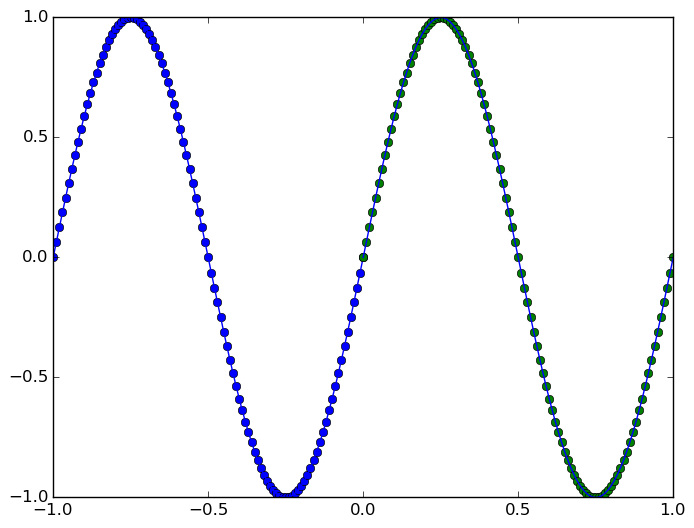

1.6541978897777199e-9

In [102]:
using PyPlot
x = [(1-ξ)*el.a/2 + (1+ξ)*el.b/2 for el in elems]
maxerr = 0.0

for e = 1:nel
    uu = resp(x[e])
    err = maxabs(uu-Ue[:,e])
    if err > maxerr maxerr = err end
    plot(x[e], Ue[:,e],"o")
    plot(x[e], uu, "b")
end
maxerr